In [1]:
import netCDF4
import numpy as np
import pandas as pd
import os
import xarray as xr
from fbprophet.utilities import regressor_coefficients
import pandas as pd
from fbprophet import Prophet


Importing plotly failed. Interactive plots will not work.


# Load MERRA-2

In [2]:
f_names = os.listdir("../data")
f_names = filter(lambda f:"nc4" in f,f_names)
def load_netcdf(f_path:str)-> pd.DataFrame:
    ds = xr.open_dataset(f_path)
    df = ds.to_dataframe()
    return df
dfs = [load_netcdf(os.path.join("../data",f_name)) for f_name in f_names]

In [3]:
data = pd.concat(dfs)

In [4]:
data = data.sort_index()

In [5]:
data.columns
data.drop(['LWGAB', 
           'CLDTOT', 
           'ALBNIRDF',
           'LWTUPCLRCLN',
           'CLDHGH', 
           'LWGABCLR', 
           'LWGABCLRCLN', 
           'LWGNTCLRCLN', 
           'LWGEM', 
           'CLDMID',
           'TS',
            "ALBVISDF",
           "ALBNIRDR",
           "ALBVISDR",
           "EMIS",
          "LWGNTCLR",
          "LWGNT",
          "LWTUPCLR",
          "LWTUP"],axis=1,inplace=True)

In [6]:
data_terminator = data.query('lat > -66 & lat <66')

In [7]:
def lat_weight(lat:float) -> float:
    return abs(np.sin(np.radians(lat-0.5))-np.sin(np.radians(lat+0.5)))

In [8]:
weights = []
for index, group in data_terminator.groupby(level="lat"):
    weight = lat_weight(index)
    weights.append(weight)

In [9]:
i=0 
for index, group in data_terminator.groupby(level="lat"):
    data_terminator.loc[(slice(None), index,slice(None)),"weights"] = weights[i] 
    i+=1


/var/folders/8_/qfq2f03j40x2lyrbnm67xqm40000gn/T/ipykernel_23723/1685869397.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_terminator.loc[(slice(None), index,slice(None)),"weights"] = weights[i]


In [10]:
data_terminator['wtoa_sw_all_mon']=data_terminator['SWTNT']*data_terminator['weights']
data_terminator['wSWTNT']=data_terminator['SWTNT']*data_terminator['weights']

data_terminator['wtoa_sw_clr_c_all_mon']=data_terminator['SWTNTCLRCLN']*data_terminator['weights']
data_terminator['wsolar_mon']=data_terminator['SWTDN']*data_terminator['weights']
data_terminator['wSWTDN']=data_terminator['SWTDN']*data_terminator['weights']

/var/folders/8_/qfq2f03j40x2lyrbnm67xqm40000gn/T/ipykernel_23723/393081301.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_terminator['wtoa_sw_all_mon']=data_terminator['SWTNT']*data_terminator['weights']
/var/folders/8_/qfq2f03j40x2lyrbnm67xqm40000gn/T/ipykernel_23723/393081301.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_terminator['wSWTNT']=data_terminator['SWTNT']*data_terminator['weights']
/var/folders/8_/qfq2f03j40x2lyrbnm67xqm40000gn/T/ipykernel_23723/393081301.py:4: SettingWithC

# Load CERES

In [11]:
f_avg = "CERES_EBAF-TOA_Ed4.1_Subset_200003-202203.nc"
f_lat_lon = "CERES_EBAF-TOA_Ed4.1_Subset_200003-202203-lat-lon.nc"

f_names = [f_avg,f_lat_lon]
def load_netcdf(f_path:str)-> pd.DataFrame:
    ds = xr.open_dataset(f_path)
    df = ds.to_dataframe()
    
    return df
dfs = [load_netcdf(os.path.join("../data",f_name)) for f_name in f_names]

In [12]:
data_cerres = dfs[1].copy()
data_cerres = data_cerres.query('lat > -66 & lat <66')
weights = []
for index, group in data_cerres.groupby(level="lat"):
    weight = lat_weight(index)
    weights.append(weight)
data_cerres["albedo"] = data_cerres["toa_sw_all_mon"]/data_cerres["solar_mon"]
data_cerres["albedo_clr"] = data_cerres["toa_sw_clr_c_mon"]/data_cerres["solar_mon"]
i=0 
for index, group in data_cerres.groupby(level="lat"):
    data_cerres.loc[(slice(None), index,slice(None)),"weights"] = weights[i] 
    i+=1
data_cerres['wtoa_sw_all_mon']=data_cerres['toa_sw_all_mon']*data_cerres['weights']
data_cerres['wtoa_sw_clr_c_all_mon']=data_cerres['toa_sw_clr_c_mon']*data_cerres['weights']
data_cerres['wsolar_mon']=data_cerres['solar_mon']*data_cerres['weights']

In [99]:
data_cerres['wtoa_sw_all_mon']

AttributeError: 'SeriesGroupBy' object has no attribute 'groupby'

In [19]:
data_agg_cerres = data_cerres.groupby(level="time").mean()


#  Albedo  MERRA-2 vs. CERES

In [20]:
data_agg = data_terminator.groupby(level="time").mean()
data_agg["absorb"] = data_agg['wtoa_sw_all_mon']/data_agg['wsolar_mon']

In [88]:
data_agg["albedo"] = 1 - data_agg["absorb"]
data_agg["SWRF"] = data_agg["SWTDN"]-data_agg["SWTNT"]

In [104]:
data_agg.index = pd.to_datetime(data_agg.index)
data_agg_cerres.index = pd.to_datetime(data_agg_cerres.index)


## Short Wave Reflected Flux 
#### Question; For CERES SWRF seems to be the field toa_sw_all_mon, for MERRA-2 are we correct in assuming SWRF=SWTDN-SWTNT?

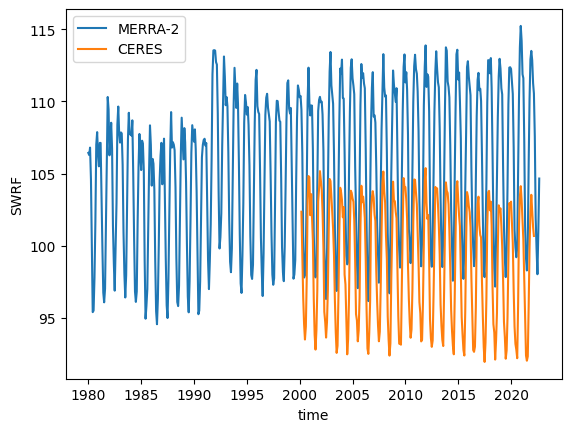

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
# plt.text(x, .5, 'hello', transform=trans)
sns.lineplot(data_agg["SWRF"],label = "MERRA-2")#,ax = axarrs[0])
alb = sns.lineplot(data_agg_cerres["toa_sw_all_mon"],label = "CERES")#,ax = axarrs[0])

# alb.axvline(pd.to_datetime("1991-06-01"),c="red")
# plt.text(pd.to_datetime("1991-10-01"), 1.60, 'Pinatubo')

# alb.axvline(pd.to_datetime("1982-03-01"),c="red")
# plt.text(pd.to_datetime("1982-09-01"), 1.60, 'El Chichón')
# plt.title("Short Wave Reflected Flux")
# alb.set_ylabel("Short Wave Reflected Flux")
# alb.set_xlabel("Time")
# plt.ylim(1.25,1.65)
# plt.legend()

# , 03/28/1982

Text(0, 0.5, '12-step rolling avg. Shortwave Reflected Flu')

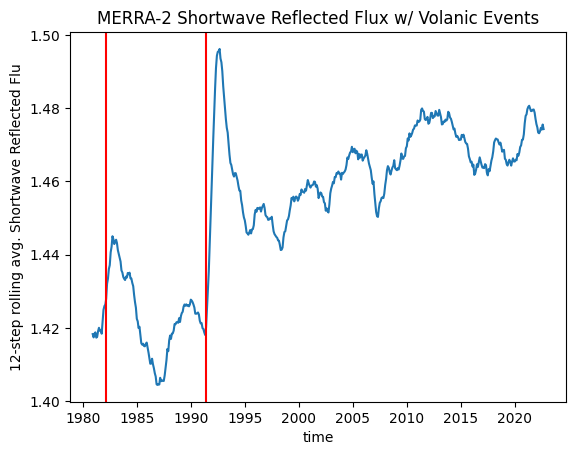

In [24]:
alb = sns.lineplot((data_agg["SWRF"]).rolling(window=12).mean() )#,ax = axarrs[0])
alb.axvline(pd.to_datetime("1991-06-01"),c="red",label="Pinatubo")
# plt.text(pd.to_datetime("1991-10-01"), 238.6, 'Pinatubo')

alb.axvline(pd.to_datetime("1982-03-01"),c="red")
# plt.text(pd.to_datetime("1982-09-01"), 238.6, 'El Chichón')
plt.title("MERRA-2 Shortwave Reflected Flux w/ Volanic Events")
alb.set_ylabel("12-step rolling avg. Shortwave Reflected Flu")


In [25]:
# data_agg_cerres["albedo"]
data_agg.index = pd.to_datetime(data_agg.index).strftime('%Y-%m')
data_agg_cerres.index = pd.to_datetime(data_agg_cerres.index).strftime('%Y-%m')


In [26]:
absolute_difference = (data_agg_cerres["wtoa_sw_all_mon"]-data_agg["SWRF"]).dropna()

In [27]:
percentage_difference = 100*((data_agg_cerres["wtoa_sw_all_mon"]-data_agg["SWRF"])/(data_agg_cerres["wtoa_sw_all_mon"])).dropna()

In [28]:
percentage_difference.index  = pd.to_datetime(percentage_difference.index)
absolute_difference.index  = pd.to_datetime(absolute_difference.index)

In [29]:
cerres = data_agg_cerres["wtoa_sw_all_mon"]
cerres.index = pd.to_datetime(cerres.index)

In [30]:
merra2 = data_agg["SWRF"]
merra2.index = pd.to_datetime(merra2.index)

In [31]:
albedo_merge = pd.merge(cerres,merra2,left_index=True,right_index=True,)

In [32]:
albedo_merge.reset_index(drop=True,inplace=True)

In [33]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(albedo_merge["wtoa_sw_all_mon"],albedo_merge["SWRF"],squared=False)

In [34]:
print(rmse)

0.1147086644803288


0.1147086644803288


Text(2010-01-01 00:00:00, -5, 'RMSE: .11')

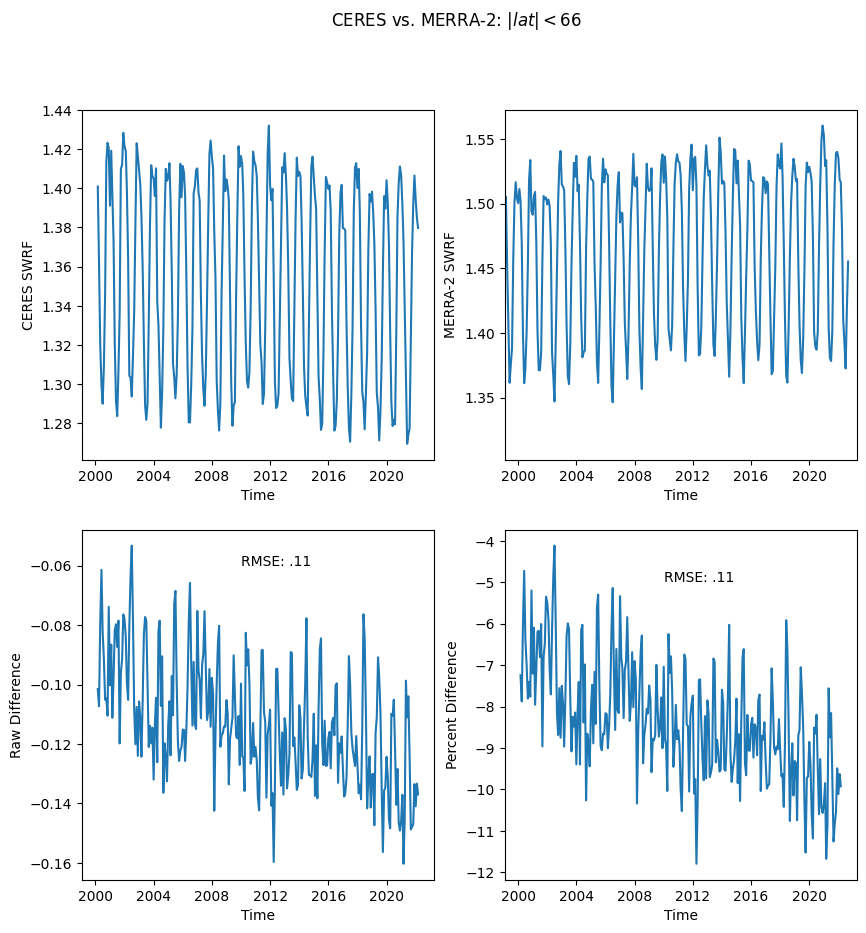

In [35]:
fig, axarrs = plt.subplots(2, 2,figsize=(10,10))
fig.suptitle(r"CERES vs. MERRA-2: $|lat| < 66$", fontsize=12)

print(rmse)
sns.lineplot(cerres,ax=axarrs[0][0])
axarrs[0][0].set_ylabel("CERES SWRF")
axarrs[0][0].set_xlabel("Time")
# axarrs[0][0].set_ylim(.26,.32)

sns.lineplot(merra2,ax=axarrs[0][1])
axarrs[0][1].set_ylabel("MERRA-2 SWRF")
axarrs[0][1].set_xlabel("Time")
axarrs[0][1].set_xlim(axarrs[0][0].get_xlim())
# axarrs[0][1].set_ylim(.26,.32)

rmse = mean_squared_error(albedo_merge["toa_sw_all_mon"],
                          albedo_merge["SWRF"],
                          squared=False)

sns.lineplot(absolute_difference,ax=axarrs[1][0])
axarrs[1][0].set_ylabel("Raw Difference")
axarrs[1][0].set_xlabel("Time")
axarrs[1][0].text(pd.to_datetime(("2010-01-01")),-.06,"RMSE: .11")


sns.lineplot(percentage_difference,ax=axarrs[1][1])
axarrs[1][1].set_ylabel("Percent Difference")
axarrs[1][1].set_xlabel("Time")
axarrs[1][1].text(pd.to_datetime(("2010-01-01")),-5,"RMSE: .11")


## Remove Trend/Seasonality

In [87]:
import multiprocessing
# multiprocessing.set_start_method("fork")
data_agg_cerres
data_agg_cerres["ds"] = data_agg_cerres.index
data_agg_cerres["y"] = data_agg_cerres.toa_sw_all_mon
# group.drop(["ALBEDO"],axis=1,inplace=True)
m = Prophet(mcmc_samples=4000)


m.fit(data_agg_cerres)
# regressor_df = regressor_coefficients(m)
# regressor_df["lat"]  = index
# regressor_dfs.append(regressor_df)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/samuelkahn/Desktop/ClimateAIResearch/climate-ai/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, b


Gradient evaluation took 0.000656 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.56 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000181 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.81 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000191 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.91 seconds.

Adjust your expectations accordingly!


Gradient evaluation took 0.000143 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.43 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 4000 [  0%]  (Warmup)
Iteration:    1 / 4000 [  0%]  (Warmup)
Iteration:    1 / 4000 [  0%]  (Warmup)
Iteration:    1 / 4000 [  0%]  (Warmup)
Iteration:  400 / 4000 [ 10%]  (Warmup)
Iteration:  400 / 4000 [ 10%]  (Warmup)
Iteration:  400 / 4000 [ 10%]  (Warmup)
Iteration:  400 / 4000 [ 10%]  (Warmup)
Iteration:  800 / 4000 [

/Users/samuelkahn/Desktop/ClimateAIResearch/climate-ai/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/samuelkahn/Desktop/ClimateAIResearch/climate-ai/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/samuelkahn/Desktop/ClimateAIResearch/climate-ai/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


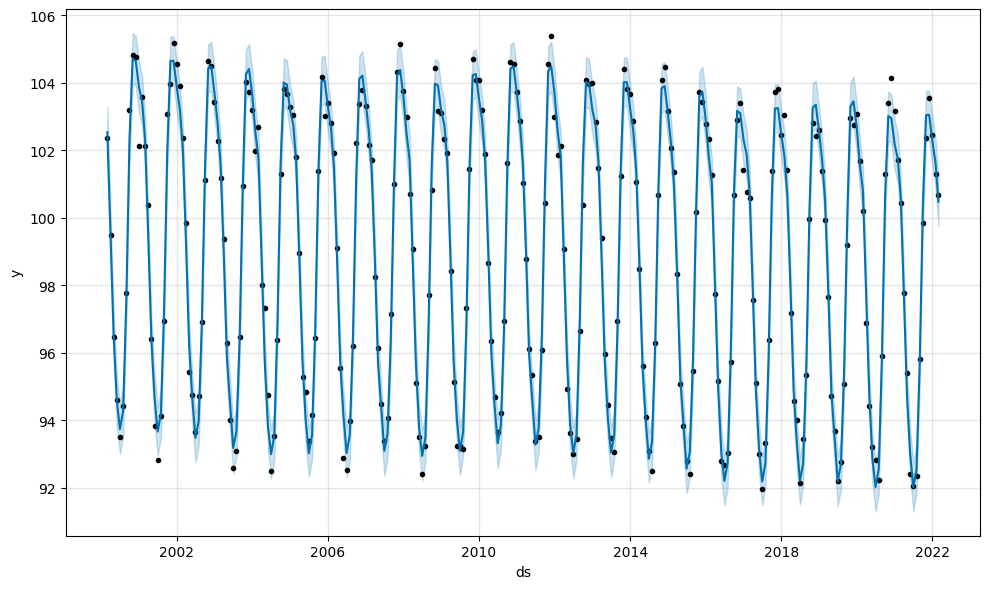

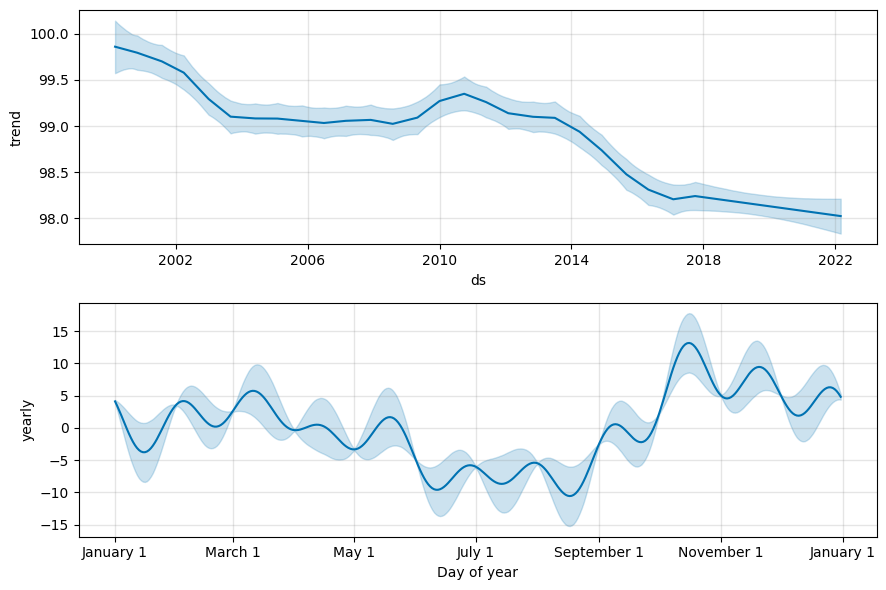

In [89]:
forecast = m.predict(data_agg_cerres)
fig1 = m.plot(forecast)
fig = m.plot_components(forecast)


In [100]:
data_agg_cerres.index = pd.to_datetime(data_agg_cerres.index)

forecast.index = pd.to_datetime(data_agg_cerres.index)
y = data_agg_cerres["y"] - forecast["yearly"] - forecast["trend"]

In [101]:
data_agg_cerres.tail()

,toa_sw_all_mon,toa_lw_all_mon,toa_net_all_mon,toa_sw_clr_c_mon,toa_lw_clr_c_mon,toa_net_clr_c_mon,solar_mon,cldarea_total_daynight_mon,cldpress_total_daynight_mon,cldtemp_total_daynight_mon,cldtau_total_day_mon,albedo,albedo_clr,weights,wtoa_sw_all_mon,wtoa_sw_clr_c_all_mon,wsolar_mon,ds,y
time,,,,,,,,,,,,,,,,,,,
2021-11-01,102.360764,238.364990,5.531259,48.392662,267.079865,30.785265,346.256836,70.283005,596.293884,257.661438,5.328031,0.323195,0.164188,0.013842,1.392091,0.665758,4.986718,2021-11-01,102.360764
2021-12-01,103.534828,236.994797,7.121833,46.625557,265.370483,35.655293,347.650909,70.195129,598.638245,257.204773,5.342954,0.338884,0.180682,0.013842,1.406475,0.652763,4.976261,2021-12-01,103.534828
2022-01-01,102.456741,237.063171,9.500158,46.928242,265.560913,36.531067,349.019897,68.903252,598.957520,257.067505,5.367930,0.329204,0.173870,0.013842,1.394207,0.663244,5.013344,2022-01-01,102.456741
2022-02-01,101.288849,238.724579,9.652493,50.069981,266.580078,33.015816,349.666260,66.773346,601.542603,257.845459,5.243274,0.318436,0.170681,0.013842,1.384829,0.701463,5.064084,2022-02-01,101.288849
2022-03-01,100.683777,238.972183,7.363034,52.872681,267.700653,26.444313,347.019165,68.044006,588.931824,257.037170,5.021815,0.312037,0.165529,0.013842,1.379718,0.728259,5.048020,2022-03-01,100.683777


Text(0.5, 1.0, 'CERES SWRF-(Yearly Seasonality)')

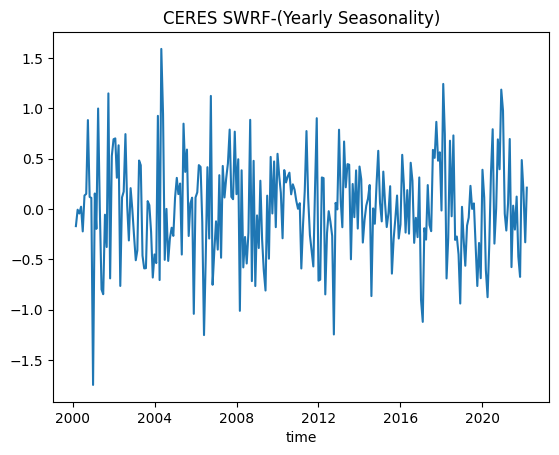

In [102]:
sns.lineplot(y)
plt.title("CERES SWRF-(Yearly Seasonality)")

## Clear-sky Shortwave Radiation Albedo 
#### Dan Note: Do you have other variables from MERRA-2?  Do you have clear-sky shortwave flux at TOA like CERES does?  If so, let's produce similar plots to what you produced above, but for clear-sky.  This is another check on MERRA-2.

In [101]:
data_terminator['wtoa_clr_sw_all_mon']=data_terminator['SWTNTCLRCLN']*data_terminator['weights']

/var/folders/8_/qfq2f03j40x2lyrbnm67xqm40000gn/T/ipykernel_7456/2881845929.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_terminator['wtoa_clr_sw_all_mon']=data_terminator['SWTNTCLRCLN']*data_terminator['weights']


In [102]:
data_agg = data_terminator.groupby(level="time").mean()
data_agg["absorb_clr"] = data_agg['wtoa_clr_sw_all_mon']/data_agg['wsolar_mon']
data_agg["albedo_clr"] = 1 - data_agg["absorb_clr"]

In [103]:
data_agg.index  = pd.to_datetime(data_agg.index)

Text(0, 0.5, 'Albedo Clear Sky')

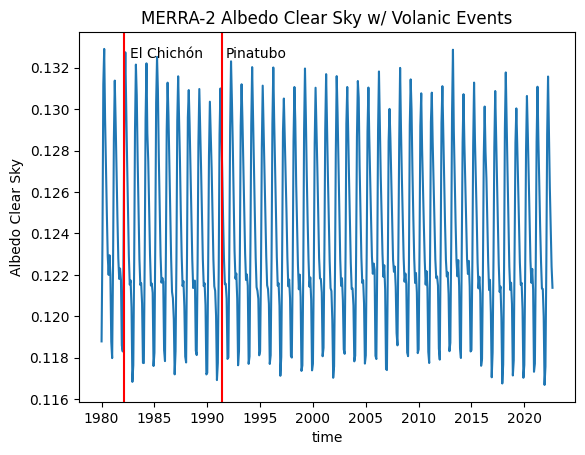

In [104]:
alb_clr = sns.lineplot(data_agg["albedo_clr"])#,ax = axarrs[0])

alb_clr.axvline(pd.to_datetime("1991-06-01"),c="red",label="Pinatubo")
plt.text(pd.to_datetime("1991-10-01"), .1325, 'Pinatubo')

alb_clr.axvline(pd.to_datetime("1982-03-01"),c="red")
plt.text(pd.to_datetime("1982-09-01"), .1325, 'El Chichón')
plt.title("MERRA-2 Albedo Clear Sky w/ Volanic Events")
alb_clr.set_ylabel("Albedo Clear Sky")


# # data_agg_cerres["albedo"]


Text(0, 0.5, '12-step rolling avg. Albedo')

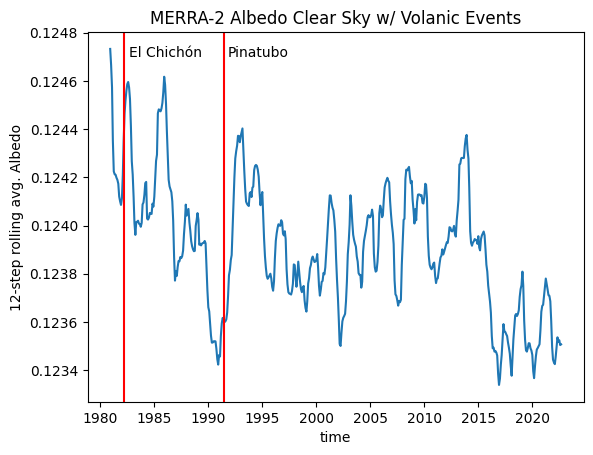

In [105]:
alb_clr = sns.lineplot(data_agg["albedo_clr"].rolling(window=12).mean() )#,ax = axarrs[0])
alb_clr.axvline(pd.to_datetime("1991-06-01"),c="red",label="Pinatubo")

plt.text(pd.to_datetime("1991-10-01"), .1247, 'Pinatubo')

alb_clr.axvline(pd.to_datetime("1982-03-01"),c="red")
plt.text(pd.to_datetime("1982-09-01"), .1247, 'El Chichón')
plt.title("MERRA-2 Albedo Clear Sky w/ Volanic Events")
alb_clr.set_ylabel("12-step rolling avg. Albedo")


0.015891412674672045


Text(2010-01-01 00:00:00, 13, 'RMSE: 1.6e-2')

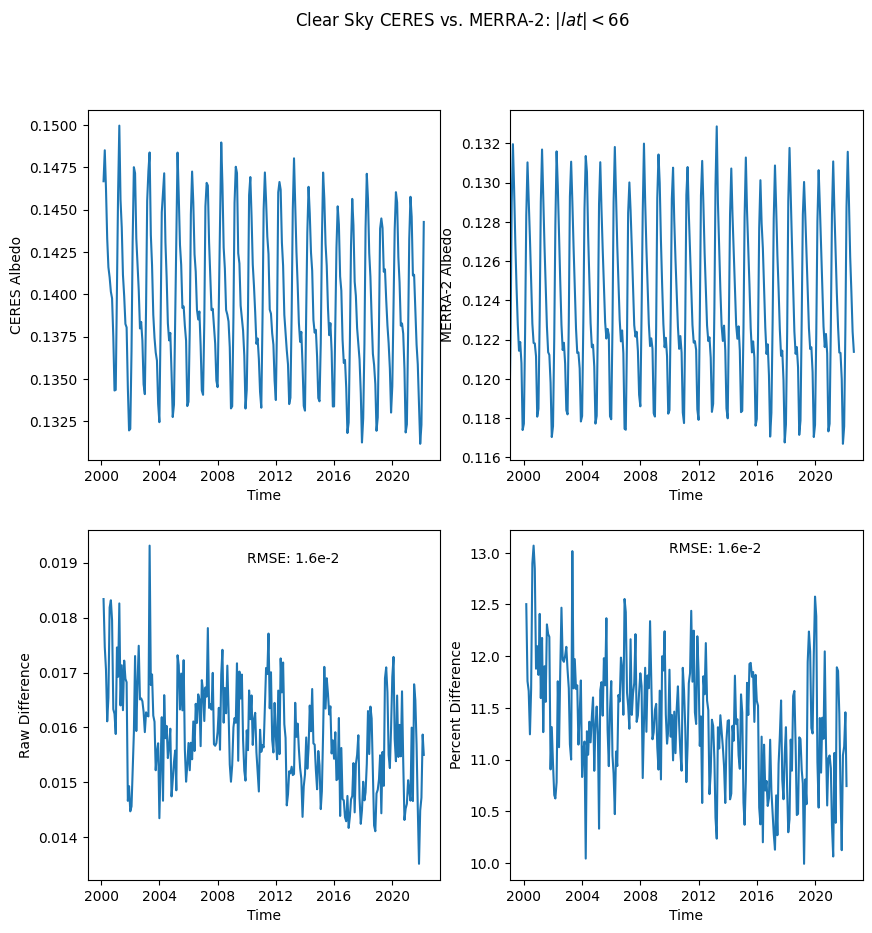

In [109]:
data_agg.index = pd.to_datetime(data_agg.index).strftime('%Y-%m')
data_agg_cerres.index = pd.to_datetime(data_agg_cerres.index).strftime('%Y-%m')


absolute_difference = (data_agg_cerres["albedo_clr"]-data_agg["albedo_clr"]).dropna()

percentage_difference = 100*((data_agg_cerres["albedo_clr"]-data_agg["albedo_clr"])/(data_agg_cerres["albedo_clr"])).dropna()

percentage_difference.index  = pd.to_datetime(percentage_difference.index)
absolute_difference.index  = pd.to_datetime(absolute_difference.index)

cerres = data_agg_cerres["albedo_clr"]
cerres.index = pd.to_datetime(cerres.index)

merra2 = data_agg["albedo_clr"]
merra2.index = pd.to_datetime(merra2.index)

albedo_merge_clr = pd.merge(cerres,merra2,left_index=True,right_index=True,)
albedo_merge_clr.reset_index(drop=True,inplace=True)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(albedo_merge_clr["albedo_clr_x"],albedo_merge_clr["albedo_clr_y"],squared=False)
print(rmse)
fig, axarrs = plt.subplots(2, 2,figsize=(10,10))
fig.suptitle(r"Clear Sky CERES vs. MERRA-2: $|lat| < 66$", fontsize=12)


sns.lineplot(cerres,ax=axarrs[0][0])
axarrs[0][0].set_ylabel("CERES Albedo")
axarrs[0][0].set_xlabel("Time")
# axarrs[0][0].set_ylim(.11, .15)

sns.lineplot(merra2,ax=axarrs[0][1])
axarrs[0][1].set_ylabel("MERRA-2 Albedo")
axarrs[0][1].set_xlabel("Time")
axarrs[0][1].set_xlim(axarrs[0][0].get_xlim())
# axarrs[0][0].set_ylim(.11, .15)

rmse = mean_squared_error(albedo_merge_clr["albedo_clr_x"],
                          albedo_merge_clr["albedo_clr_y"],
                          squared=False)

sns.lineplot(absolute_difference,ax=axarrs[1][0])
axarrs[1][0].set_ylabel("Raw Difference")
axarrs[1][0].set_xlabel("Time")
axarrs[1][0].text(pd.to_datetime(("2010-01-01")),.019,"RMSE: 1.6e-2")


sns.lineplot(percentage_difference,ax=axarrs[1][1])
axarrs[1][1].set_ylabel("Percent Difference")
axarrs[1][1].set_xlabel("Time")
axarrs[1][1].text(pd.to_datetime(("2010-01-01")),13,"RMSE: 1.6e-2")


# Bayesian Structural Time Series Adative Impact

In [ ]:
regressor_dfs = []
for index, group in data.groupby(level="lat"):
    print("-"*100)
    print(index)
    group = group.groupby("time").mean().interpolate()
    
    group["ds"] = group.index
    group["y"] = ngroup.ALBEDO
    group.drop(["ALBEDO"],axis=1,inplace=True)
    m = Prophet()

    for col in group.columns:
        if col not in ["y","ds"]:
            m.add_regressor(col)
    m.fit(group)
    regressor_df = regressor_coefficients(m)
    regressor_df["lat"]  = index
    regressor_dfs.append(regressor_df)
    

In [ ]:
regressor_dfs_concat = pd.concat(regressor_dfs)

In [ ]:
regressor_dfs_concat

In [ ]:
import matplotlib.pyplot as plt
subset = regressor_dfs_concat[regressor_dfs_concat["regressor"] == "CLDHGH"].reset_index(drop=True)
unique_labels = regressor_dfs_concat["regressor"].unique()

In [ ]:
axarr[0][0]

In [ ]:
fig, axarr = plt.subplots(2, 4,figsize=(30,15))
print(axarr)
i=0
for label in unique_labels:
    subset = regressor_dfs_concat[regressor_dfs_concat["regressor"] == label]
    if i<=3:
        plot_ax = axarr[0][i]
    else:
        plot_ax = axarr[1][i-4]
    sns.lineplot(x="lat",y="coef",data = subset,ax=plot_ax)
    plot_ax.set_ylabel(f"Additive Impact of Unit increase in {label} on Albedo")
    plot_ax.set_xlabel(f"Latitude")
    plot_ax.set_title(f"Additive Impact of {label} on Albedo vs. Latitude")


    i+=1

In [ ]:
regressor_dfs_log = []

for index, group in data_log.groupby(level="lat"):
    print("-"*100)
    print(index)
    group = group.groupby("time").mean().interpolate()
    
    group["ds"] = group.index
    group["y"] = group.ALBEDO
    group.drop(["ALBEDO"],axis=1,inplace=True)
    m = Prophet()

    for col in group.columns:
        if col not in ["y","ds"]:
            m.add_regressor(col)
    
    m.fit(group.dropna()) #quick and dirty hack to handle NaNs
    regressor_df = regressor_coefficients(m)
    regressor_df["lat"]  = index
    regressor_dfs_log.append(regressor_df)

In [ ]:
regressor_dfs_concat_log = pd.concat(regressor_dfs_log)
fig, axarr = plt.subplots(2, 4,figsize=(30,15))
print(axarr)
i=0
for label in unique_labels:
    subset = regressor_dfs_concat_log[regressor_dfs_concat_log["regressor"] == label]
    if i<=3:
        plot_ax = axarr[0][i]
    else:
        plot_ax = axarr[1][i-4]
    sns.lineplot(x="lat",y="coef",data = subset,ax=plot_ax)
    plot_ax.set_ylabel(f"Additive Impact of {label} on Albedo")
    plot_ax.set_xlabel(f"Latitude")
    plot_ax.set_title(f"Additive Impact of {label} on Albedo vs. Latitude")


    i+=1

In [ ]:
group

In [ ]:
weights = []
for index, group in data.groupby(level="lat"):
    weight = lat_weight(index)
    weights.append(weight)

In [ ]:
i=0 
for index, group in data.groupby(level="lat"):
    data.loc[(slice(None), index,slice(None)),"weights"] = weights[i] 
    i+=1


In [ ]:
data['wtoa_sw_all_mon']=data['SWTNT']*data['weights']
data['wsolar_mon']=data['SWGDN']*data['weights']
fig, axarrs = plt.subplots(1, 2,figsize=(18,6))
fig.suptitle("Our Calculation vs. Global Means", fontsize=14)

data_agg = data.groupby(level="time").mean()
data_agg["albedo"] = data_agg['wtoa_sw_all_mon']/data_agg['wsolar_mon']
sns.lineplot(data_agg["albedo"],label="Our Calculation",ax = axarrs[0])
# axarrs[0].text(pd.to_datetime(2016), 0.3,'Text Here', fontsize=9) 
sns.lineplot(global_mean["albedo"],label="Global Mean",ax = axarrs[1],c="red")

# sns.lineplot(data_agg["albedo"],label="Our Calculation",ax = axarrs[2])
sns.lineplot(global_mean["albedo"],label="Global Mean",ax = axarrs[2],c="red")

In [ ]:
fig, axarrs = plt.subplots(1, 2,figsize=(18,6))
fig.suptitle("Our Calculation vs. Global Means", fontsize=14)

data_agg = data.groupby(level="time").mean()
data_agg["albedo"] = data_agg['wtoa_sw_all_mon']/data_agg['wsolar_mon']
sns.lineplot(data_agg["albedo"],label="Our Calculation",ax = axarrs[0])
# axarrs[0].text(pd.to_datetime(2016), 0.3,'Text Here', fontsize=9) 
sns.lineplot(global_mean["albedo"],label="Global Mean",ax = axarrs[1],c="red")

# sns.lineplot(data_agg["albedo"],label="Our Calculation",ax = axarrs[2])
sns.lineplot(global_mean["albedo"],label="Global Mean",ax = axarrs[2],c="red")

In [ ]:
data_agg

In [ ]:
d

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
time_data = data.groupby(level="time").mean()
sns.lineplot(time_data.ALBEDO)
plt.title("MERRA-2")

In [ ]:
sns.lineplot(time_data.SWGDN)
plt.title("MERRA-2")

# Globally Average Data Pull

In [13]:
f_avg = "CERES_EBAF-TOA_Ed4.1_Subset_200003-202203.nc"
f_lat_lon = "CERES_EBAF-TOA_Ed4.1_Subset_200003-202203-lat-lon.nc"

f_names = [f_avg,f_lat_lon]
def load_netcdf(f_path:str)-> pd.DataFrame:
    ds = xr.open_dataset(f_path)
    df = ds.to_dataframe()
    
    return df
dfs = [load_netcdf(os.path.join("../data",f_name)) for f_name in f_names]

<AxesSubplot: xlabel='time', ylabel='albedo'>

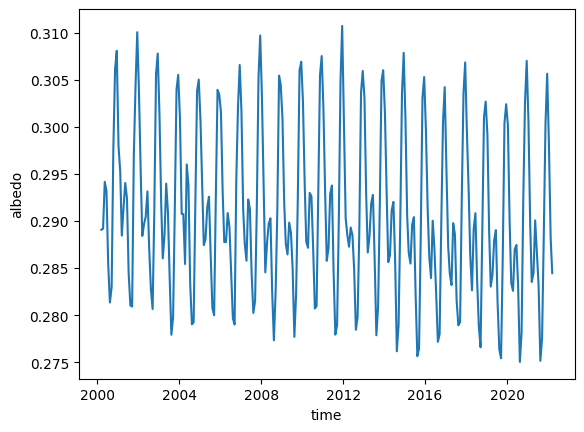

In [14]:
import seaborn as sns 
import matplotlib.pyplot as plt
global_mean = dfs[0].copy()
global_mean["albedo"] = global_mean["gtoa_sw_all_mon"]/global_mean["gsolar_mon"]

#  (TOA outgoing flux)/(solar flux)
sns.lineplot(global_mean["albedo"])

# LAT-LON GRID PULL


## Surface Area correction

In [103]:
import numpy as np 
import math 
Rearth = 6378.137
delta_lat=1
delta_lon=1


In [104]:
def lat_weight(lat:float) -> float:
    return abs(np.sin(np.radians(lat-0.5))-np.sin(np.radians(lat+0.5)))

In [17]:

data_cerres = dfs[1].copy()
data_cerres = data_cerres.query('lat > -66 & lat <66')
weights = []
for index, group in data_cerres.groupby(level="lat"):
    weight = lat_weight(index)
    weights.append(weight)
data_cerres["albedo"] = data_cerres["toa_sw_all_mon"]/data_cerres["solar_mon"]
data_cerres["albedo_clr"] = data_cerres["toa_sw_clr_c_mon"]/data_cerres["solar_mon"]
i=0 
for index, group in data_cerres.groupby(level="lat"):
    data_cerres.loc[(slice(None), index,slice(None)),"weights"] = weights[i] 
    i+=1
data_cerres['wtoa_sw_all_mon']=data_cerres['toa_sw_all_mon']*data_cerres['weights']
data_cerres['wtoa_sw_clr_c_all_mon']=data_cerres['toa_sw_clr_c_mon']*data_cerres['weights']
data_cerres['wsolar_mon']=data_cerres['solar_mon']*data_cerres['weights']

In [18]:
data_cerres["wtoa_sw_all_mon"]

KeyError: 'wtoa_sw_all_mon'

In [19]:
assert len(set(data_cerres.index.get_level_values("lat"))) == len(weights)

In [21]:
i=0 
for index, group in data_cerres.groupby(level="lat"):
    data_cerres.loc[(slice(None), index,slice(None)),"weights"] = weights[i] 
    i+=1


In [22]:
data_cerres['wtoa_sw_all_mon']=data_cerres['toa_sw_all_mon']*data_cerres['weights']
data_cerres['wtoa_sw_clr_c_all_mon']=data_cerres['toa_sw_clr_c_mon']*data_cerres['weights']
data_cerres['wsolar_mon']=data_cerres['solar_mon']*data_cerres['weights']

<AxesSubplot: xlabel='time', ylabel='wtoa_sw_all_mon'>

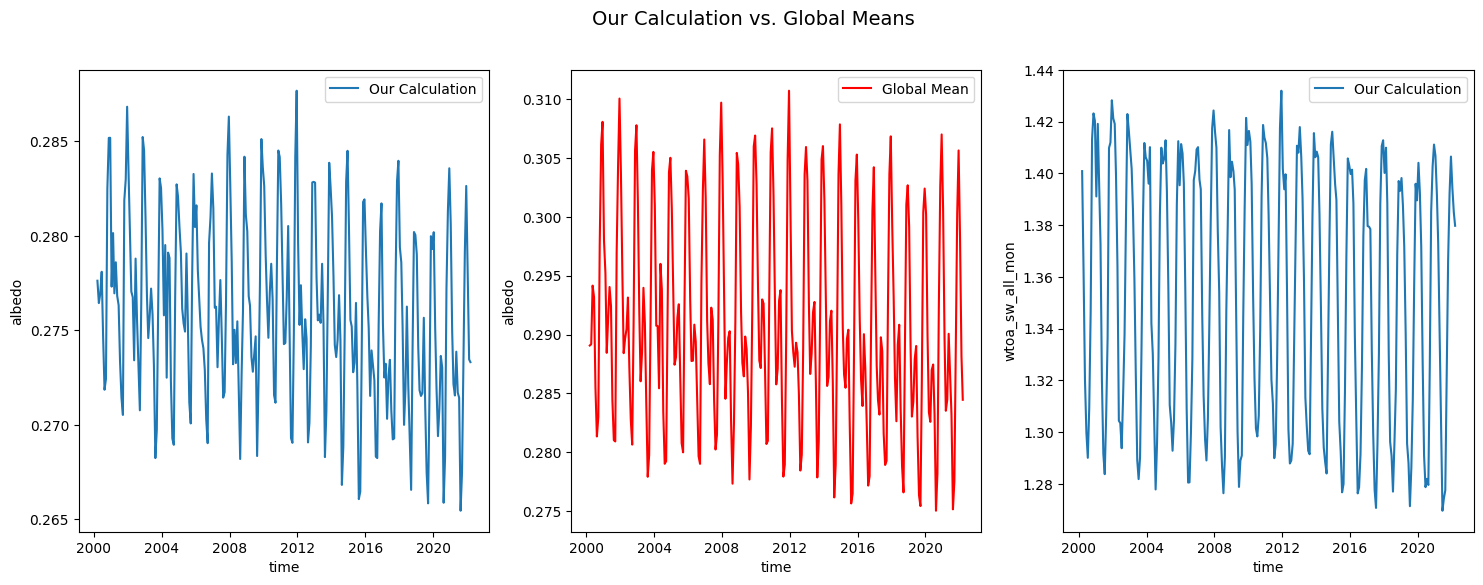

In [23]:
fig, axarrs = plt.subplots(1, 3,figsize=(18,6))
fig.suptitle("Our Calculation vs. Global Means", fontsize=14)

data_agg_cerres = data_cerres.groupby(level="time").mean()
data_agg_cerres["albedo"] = data_agg_cerres['wtoa_sw_all_mon']/data_agg_cerres['wsolar_mon']
data_agg_cerres["albedo_clr"] = data_agg_cerres['wtoa_sw_clr_c_all_mon']/data_agg_cerres['wsolar_mon']

sns.lineplot(data_agg_cerres["albedo"],label="Our Calculation",ax = axarrs[0])
# axarrs[0].text(pd.to_datetime(2016), 0.3,'Text Here', fontsize=9) 
sns.lineplot(global_mean["albedo"],label="Global Mean",ax = axarrs[1],c="red")

sns.lineplot(data_agg_cerres["wtoa_sw_all_mon"],label="Our Calculation",ax = axarrs[2])
# sns.lineplot(global_mean["albedo"],label="Global Mean",ax = axarrs[2],c="red")

In [117]:
data_cerres

toa_sw_all_mon  toa_lw_all_mon  toa_net_all_mon  \
lon   lat   time                                                          
0.5   -89.5 2000-03-15       43.849998      139.600006      -126.400002   
            2000-04-15        0.162000      123.900002      -124.099998   
            2000-05-15        0.049000      120.400002      -120.500000   
            2000-06-15        0.047000      116.900002      -116.900002   
            2000-07-15        0.049000      112.400002      -112.400002   
...                                ...             ...              ...   
359.5  89.5 2021-11-15        0.049000      174.600006      -174.699997   
            2021-12-15        0.000000      172.100006      -172.100006   
            2022-01-15        0.049000      164.899994      -164.899994   
            2022-02-15        0.076000      169.899994      -170.000000   
            2022-03-15       15.920000      177.699997      -173.899994   

                        toa_sw_clr_c_mon  toa_lw_clr_c_mon  toa_net_clr_c_mon  \
lon   lat   time                                                                
0.5   -89.5 2000-03-15         64.470001        136.600006        -143.899994   
            2000-04-15          0.023000        120.000000        -120.000000   
            2000-05-15          0.000000        114.400002        -114.400002   
            2000-06-15          0.001000        113.000000        -113.000000   
            2000-07-15          0.001000        106.500000        -106.500000   
...                                  ...               ...                ...   
359.5  89.5 2021-11-15          0.104000        180.800003        -180.899994   
            2021-12-15          0.011000        175.899994        -176.000000   
            2022-01-15          0.006000        169.100006        -169.100006   
            2022-02-15          0.019000        171.300003        -171.300003   
            2022-03-15         38.549999        178.399994        -197.199997   

                        solar_mon  cldarea_total_daynight_mon  \
lon   lat   time                                                
0.5   -89.5 2000-03-15  57.130001                   39.996902   
            2000-04-15   0.000000                   29.147787   
            2000-05-15   0.000000                   39.199551   
            2000-06-15   0.000000                   33.485081   
            2000-07-15   0.000000                   54.086681   
...                           ...                         ...   
359.5  89.5 2021-11-15   0.000000                   82.046333   
            2021-12-15   0.000000                   77.764137   
            2022-01-15   0.000000                   74.473236   
            2022-02-15   0.000000                   87.296547   
            2022-03-15  19.719999                   78.724976   

                        cldpress_total_daynight_mon  \
lon   lat   time                                      
0.5   -89.5 2000-03-15                   540.877380   
            2000-04-15                   581.843079   
            2000-05-15                   525.753479   
            2000-06-15                   412.346252   
            2000-07-15                   450.323853   
...                                             ...   
359.5  89.5 2021-11-15                   815.663879   
            2021-12-15                   815.907471   
            2022-01-15                   761.559875   
            2022-02-15                   780.518921   
            2022-03-15                   741.112488   

                        cldtemp_total_daynight_mon  cldtau_total_day_mon  \
lon   lat   time                                                           
0.5   -89.5 2000-03-15                  228.533188              6.037879   
            2000-04-15                  221.777603                   NaN   
            2000-05-15                  223.629944                   NaN   
            2000-06-15                  217.672714  

/Users/samuelkahn/Desktop/ClimateAIResearch/climate-ai/lib/python3.9/site-packages/seaborn/_oldcore.py:786: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  plot_data = pd.DataFrame(plot_data)
/Users/samuelkahn/Desktop/ClimateAIResearch/climate-ai/lib/python3.9/site-packages/seaborn/relational.py:438: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sub_data = grouped.apply(agg, other).reset_index()


ValueError: cannot insert x, already exists

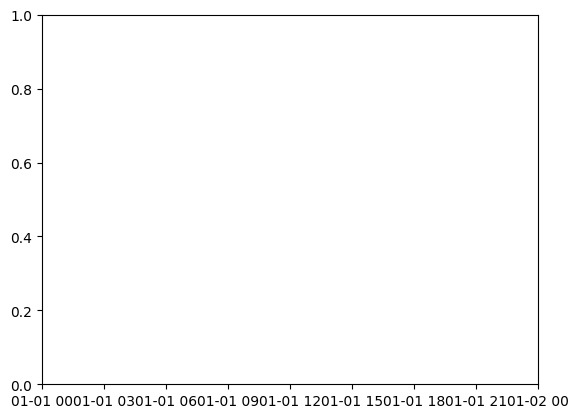

In [32]:
sns.lineplot(global_mean["albedo"]-data_agg["albedo"])
plt.title("Absolute Difference")
plt.ylabel("Global Mean - Our Calculation")

### Looks better! 

# Additive Impact 

In [ ]:
import multiprocessing
# multiprocessing.set_start_method("fork")
regressor_dfs = []
for index, group in data.groupby(level="lat"):
    print("-"*100)
    print(index)
    group = group.groupby("time").mean()
    group["weighted_albedo"] = (group['wtoa_sw_all_mon']/group['wsolar_mon']).astype(float)
    group["y"] = group.weighted_albedo
    group.replace([np.inf, -np.inf], np.nan,inplace = True)
    group = group.interpolate()
    group["ds"] = group.index
    print(group["y"])
    group.drop(["weighted_albedo",
                "wtoa_sw_all_mon",
                "wsolar_mon",
                "toa_sw_all_mon",
                "solar_mon",
                "albedo",
                "weights"],axis=1,inplace=True)
    m = Prophet(mcmc_samples=1000)

    for col in group.columns:
        if col not in ["y","ds"]:
            m.add_regressor(col)
    m.fit(group)
    regressor_df = regressor_coefficients(m)
    regressor_df["lat"]  = index
    regressor_dfs.append(regressor_df)

In [ ]:
import matplotlib.pyplot as plt
# subset = regressor_dfs_concat[regressor_dfs_concat["regressor"] == "CLDHGH"].reset_index(drop=True)
regressor_dfs_concat = pd.concat(regressor_dfs)
unique_labels = regressor_dfs_concat["regressor"].unique()


In [ ]:
subset_range = False
fig, axarr = plt.subplots(3, 3,figsize=(30,20))
idx=0
for i in range(0,len(axarr)):
    for j in range(0,len(axarr[i])):
        label=unique_labels[idx]
        subset = regressor_dfs_concat[regressor_dfs_concat["regressor"] == label]

        sns.lineplot(x="lat",y="coef",data = subset,ax=axarr[i][j])
        sns.lineplot(x="lat",y="coef_upper",data = subset,ax=axarr[i][j])
        sns.lineplot(x="lat",y="coef_lower",data = subset,ax=axarr[i][j])
        axarr[i][j].fill_between(subset["lat"], subset["coef_lower"], subset["coef_upper"], alpha=.3)

        axarr[i][j].set_ylabel(f"Additive Impact of Unit increase in {label} on Albedo")
        axarr[i][j].set_xlabel(f"Latitude")
        axarr[i][j].set_title(f"Additive Impact of {label} on Albedo vs. Latitude")  
        if subset_range:
            axarr[i][j].set_ylim(-.005,.005)
        idx+=1


In [ ]:
fig, axarr = plt.subplots(3, 3,figsize=(30,30))
idx=0
for i in range(0,len(axarr)):
    for j in range(0,len(axarr[i])):
        label=unique_labels[idx]
        subset = regressor_dfs_concat[regressor_dfs_concat["regressor"] == label]
        subset = subset[np.abs(subset["lat"])<50]
#         axarr[i][j].set_xlim(-50,50)
#         axarr[i][j].set_ylim(-.002,.002)
        sns.lineplot(x="lat",y="coef",data = subset,ax=axarr[i][j])
#         sns.lineplot(x="lat",y="coef_upper",data = subset,ax=axarr[i][j])
#         sns.lineplot(x="lat",y="coef_lower",data = subset,ax=axarr[i][j])
        axarr[i][j].fill_between(subset["lat"], subset["coef_lower"], subset["coef_upper"], alpha=.3)

        axarr[i][j].set_ylabel(f"Additive Impact of Unit increase in {label} on Albedo")
        axarr[i][j].set_xlabel(f"Latitude")
        axarr[i][j].set_title(f"Additive Impact of {label} on Albedo vs. Latitude")
        idx+=1


## Quick high/low Latitude Instability Investigation

In [ ]:
isna = []
for index, group in data.groupby(level="lat"):
    group["weighted_albedo"] = (group['wtoa_sw_all_mon']/group['wsolar_mon']).astype(float)
    group.replace([np.inf, -np.inf], np.nan,inplace = True)
#     print(group)
    isna.append({"lat":index,"na_count": group["weighted_albedo"].isna().sum()})
#     break

In [ ]:
isna_df = pd.DataFrame(isna)
sns.lineplot(x = "lat",y="na_count",data=isna_df)


In [ ]:
### It appears the instability is likely due to the interpolation that we're using to fill in missing values in the time series

# Temporal Stability

In [ ]:
data_t0 = data.xs(slice('2000-03-15', '2010-01-01'), level='time',drop_level=False)
data_t1 = data.xs(slice('2010-01-01', data.index[-1][2]), level='time',drop_level=False)

In [ ]:
import multiprocessing
# multiprocessing.set_start_method("fork")
regressor_dfs_t0 = []
for index, group in data_t0.groupby(level="lat"):
    print("-"*100)
    print(index)
    group = group.groupby("time").mean()
    group["weighted_albedo"] = (group['wtoa_sw_all_mon']/group['wsolar_mon']).astype(float)
    group["y"] = group.weighted_albedo
    group.replace([np.inf, -np.inf], np.nan,inplace = True)
    group = group.interpolate()
    group["ds"] = group.index
    print(group["y"])
    group.drop(["weighted_albedo",
                "wtoa_sw_all_mon",
                "wsolar_mon",
                "toa_sw_all_mon",
                "solar_mon",
                "albedo",
                "weights"],axis=1,inplace=True)
    m = Prophet(mcmc_samples=1000)

    for col in group.columns:
        if col not in ["y","ds"]:
            m.add_regressor(col)
    m.fit(group)
    regressor_df = regressor_coefficients(m)
    regressor_df["lat"]  = index
    regressor_dfs_t0.append(regressor_df)

In [ ]:
import multiprocessing
# multiprocessing.set_start_method("fork")
regressor_dfs_t1 = []
for index, group in data_t1.groupby(level="lat"):
    print("-"*100)
    print(index)
    group = group.groupby("time").mean()
    group["weighted_albedo"] = (group['wtoa_sw_all_mon']/group['wsolar_mon']).astype(float)
    group["y"] = group.weighted_albedo
    group.replace([np.inf, -np.inf], np.nan,inplace = True)
    group = group.interpolate()
    group["ds"] = group.index
    print(group["y"])
    group.drop(["weighted_albedo",
                "wtoa_sw_all_mon",
                "wsolar_mon",
                "toa_sw_all_mon",
                "solar_mon",
                "albedo",
                "weights"],axis=1,inplace=True)
    m = Prophet(mcmc_samples=1000)

    for col in group.columns:
        if col not in ["y","ds"]:
            m.add_regressor(col)
    m.fit(group)
    regressor_df = regressor_coefficients(m)
    regressor_df["lat"]  = index
    regressor_dfs_t1.append(regressor_df)

## T < 2010-01-01

In [ ]:
regressor_dfs_concat_t0 = pd.concat(regressor_dfs_t0)
unique_labels = regressor_dfs_concat_t0["regressor"].unique()

fig, axarr = plt.subplots(3, 3,figsize=(30,30))
idx=0
for i in range(0,len(axarr)):
    for j in range(0,len(axarr[i])):
        label=unique_labels[idx]
        subset = regressor_dfs_concat_t0[regressor_dfs_concat_t0["regressor"] == label]
        subset = subset[np.abs(subset["lat"])<50]
#         axarr[i][j].set_xlim(-50,50)
#         axarr[i][j].set_ylim(-.002,.002)
        sns.lineplot(x="lat",y="coef",data = subset,ax=axarr[i][j])
#         sns.lineplot(x="lat",y="coef_upper",data = subset,ax=axarr[i][j])
#         sns.lineplot(x="lat",y="coef_lower",data = subset,ax=axarr[i][j])
        axarr[i][j].fill_between(subset["lat"], subset["coef_lower"], subset["coef_upper"], alpha=.3)

        axarr[i][j].set_ylabel(f"Additive Impact of Unit increase in {label} on Albedo")
        axarr[i][j].set_xlabel(f"Latitude")
        axarr[i][j].set_title(f"Additive Impact of {label} on Albedo vs. Latitude")
        idx+=1


## T >= 2010-01-01

In [ ]:
regressor_dfs_concat_t1 = pd.concat(regressor_dfs_t1)
unique_labels = regressor_dfs_concat_t1["regressor"].unique()

fig, axarr = plt.subplots(3, 3,figsize=(30,30))
idx=0
for i in range(0,len(axarr)):
    for j in range(0,len(axarr[i])):
        label=unique_labels[idx]
        subset = regressor_dfs_concat_t1[regressor_dfs_concat_t1["regressor"] == label]
        subset = subset[np.abs(subset["lat"])<50]
#         axarr[i][j].set_xlim(-50,50)
#         axarr[i][j].set_ylim(-.002,.002)
        sns.lineplot(x="lat",y="coef",data = subset,ax=axarr[i][j])
#         sns.lineplot(x="lat",y="coef_upper",data = subset,ax=axarr[i][j])
#         sns.lineplot(x="lat",y="coef_lower",data = subset,ax=axarr[i][j])
        axarr[i][j].fill_between(subset["lat"], subset["coef_lower"], subset["coef_upper"], alpha=.3)

        axarr[i][j].set_ylabel(f"Additive Impact of Unit increase in {label} on Albedo")
        axarr[i][j].set_xlabel(f"Latitude")
        axarr[i][j].set_title(f"Additive Impact of {label} on Albedo vs. Latitude")
        idx+=1


## Overplot 

In [ ]:
plot_cis = True
fig, axarr = plt.subplots(3, 3,figsize=(30,30))
idx=0
for i in range(0,len(axarr)):
    for j in range(0,len(axarr[i])):
        label=unique_labels[idx]
        subset_t0 = regressor_dfs_concat_t0[regressor_dfs_concat_t0["regressor"] == label]
        subset_t0 = subset_t0[np.abs(subset_t0["lat"])<50]
        
        subset_t1 = regressor_dfs_concat_t1[regressor_dfs_concat_t1["regressor"] == label]
        subset_t1 = subset_t1[np.abs(subset_t1["lat"])<50]

        sns.lineplot(x="lat",y="coef",data = subset_t0,ax=axarr[i][j],label="T >= 2010-01-01")
        sns.lineplot(x="lat",y="coef",data = subset_t1,ax=axarr[i][j],label="T < 2010-01-01")

#         sns.lineplot(x="lat",y="coef_upper",data = subset,ax=axarr[i][j])
#         sns.lineplot(x="lat",y="coef_lower",data = subset,ax=axarr[i][j])
        if plot_cis:
            axarr[i][j].fill_between(subset_t0["lat"], subset_t0["coef_lower"], subset_t0["coef_upper"], alpha=.3)
            axarr[i][j].fill_between(subset_t1["lat"], subset_t1["coef_lower"], subset_t1["coef_upper"], alpha=.3)

        axarr[i][j].set_ylabel(f"Additive Impact of Unit increase in {label} on Albedo")
        axarr[i][j].set_xlabel(f"Latitude")
        axarr[i][j].set_title(f"Additive Impact of {label} on Albedo vs. Latitude")
        idx+=1


# 10/13/2022 - Notes from Meeting with Dan 
## - 